In [1]:
# !pip install torchvision==0.12.0 numpy==1.19.2 albumentations==0.4.3 diffusers opencv-python==4.1.2.30 pudb==2019.2 invisible-watermark imageio==2.9.0 imageio-ffmpeg==0.4.2 pytorch-lightning==1.4.2 omegaconf==2.1.1
# !pip install test-tube>=0.7.5 streamlit>=0.73.1 einops==0.3.0 torch-fidelity==0.3.0 torchmetrics==0.6.0 kornia==0.6

# !pip install ftfy ipywidgets matplotlib pyrallis torch==1.12.0 diffusers==0.12.1 transformers==4.26.0 accelerate
DEVICE = 3
import os
os.environ["CUDA_VISIBLE_DEVICES"] = str(DEVICE)
print("Using GPU: {}".format(DEVICE))
%load_ext autoreload
%autoreload 2

Using GPU: 3


In [13]:

from typing import List, Dict
import torch

import sys
sys.path.append(".")
sys.path.append("..")

from pipeline_attend_and_excite import AttendAndExcitePipeline
from config import RunConfig
from run import run_on_prompt, get_indices_to_alter, read_associated_indices
from utils import vis_utils
from utils.ptp_utils import AttentionStore



# Load Model Weights (may take a few minutes)

In [44]:

NUM_DIFFUSION_STEPS = 50
GUIDANCE_SCALE = 7.5
MAX_NUM_WORDS = 77

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
stable = AttendAndExcitePipeline.from_pretrained("CompVis/stable-diffusion-v1-4").to(device)
stable = stable.to(torch.float16)
tokenizer = stable.tokenizer

safety_checker/pytorch_model.fp16.safetensors not found


Fetching 21 files:   0%|          | 0/21 [00:00<?, ?it/s]

The config attributes {'scaling_factor': 0.18215} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


# Pipeline Wrapper

In [45]:
# configurable parameters (see RunConfig for all parameters)
# scale factor- intensity of shift by gradient
# thresholds- a dictionary for iterative refinement mapping the iteration number to the attention threshold
# max_iter_to_alter- maximal inference timestep to apply Attend-and-Excite
@torch.autocast("cuda")
def run_and_display(prompts: List[str],
                    controller: AttentionStore,
                    indices_to_alter: List[int],
                    groups: List[List[int]], # EDIT
                    generator: torch.Generator,
                    run_standard_sd: bool = False,
                    scale_factor: int = 20,
                    thresholds: Dict[int, float] = {0: 0.05, 10: 0.5, 20: 0.8},
                    max_iter_to_alter: int = 25,
                    display_output: bool = False,
                    loss_type: str = "cos"
                    ):
    
    config = RunConfig(prompt=prompts[0],
                       run_standard_sd=run_standard_sd,
                       scale_factor=scale_factor,
                       thresholds=thresholds,
                       max_iter_to_alter=max_iter_to_alter,
                       loss_type=loss_type,
                       )
    
    image = run_on_prompt(model=stable,
                          prompt=prompts,
                          controller=controller,
                          token_indices=indices_to_alter,
                          groups=groups, # EDIT
                          seed=generator,
                          config=config,
                          )
    if display_output:
        display(image)
    return image

# Show Cross-Attention Per Strengthened Token

## Define your seeds, prompt and the indices to strengthen

In [46]:
all_prompts, all_groups, all_indices_to_alter = read_associated_indices(path='../multi_obj_prompts_with_association.csv', group_split_char='|',shift_idxs=1)
assert len(all_prompts) == len(all_groups) == len(all_indices_to_alter)
print("Some sample prompts and index groups:")
all_groups[5:15], all_prompts[5:15]

Some sample prompts and index groups:


([[[2, 3], [6, 7]],
  [[2, 3], [6, 7], [11, 12], [15, 16]],
  [[2, 3], [6, 7], [11, 14], [17]],
  [[2, 3], [6, 7], [10, 11], [15, 16], [19, 20]],
  [[2, 3], [6, 7], [10, 11], [15, 16, 17], [20, 21]],
  [[2, 3, 4], [7, 8, 9], [12, 13], [17, 18], [21]],
  [[2, 3, 4], [7, 8, 9], [12, 13], [17, 18, 19], [22, 24, 25]],
  [[2, 3, 4], [7, 8], [14, 15, 16], [20, 21, 22]],
  [[2, 3, 4], [6, 7, 8], [11, 14, 12], [17, 18, 19], [23, 24]],
  [[2, 3], [5, 6], [8, 9], [12, 13, 15], [18, 20, 21, 22, 23], [27, 28, 29]]],
 ['A purple car in a dark garage.',
  'A red apple, a yellow banana, and a green pear in a fruit basket.',
  'A blue pen, a yellow highlighter, and a white piece of paper on a desk.',
  'A brown chair, a black table, a green plant, and a white wall in a living room.',
  'A silver spoon, a white plate, a blue napkin, and a red wine glass on a dining table.',
  'A red stop sign, a yellow traffic light, a green tree, and a blue sky on a street.',
  "A brown teddy bear, a yellow rubber duc

In [51]:
i = 6
print(f"Selecting prompt {i} for visualization & comparison")

# Run config
prompt = all_prompts[i]
token_indices = all_indices_to_alter[i]
token_group = all_groups[i]
seeds = [21]


prompt, token_group

Selecting prompt 6 for visualization & comparison


('A red apple, a yellow banana, and a green pear in a fruit basket.',
 [[2, 3], [6, 7], [11, 12], [15, 16]])

## Stable Diffusion

  0%|          | 0/50 [00:00<?, ?it/s]

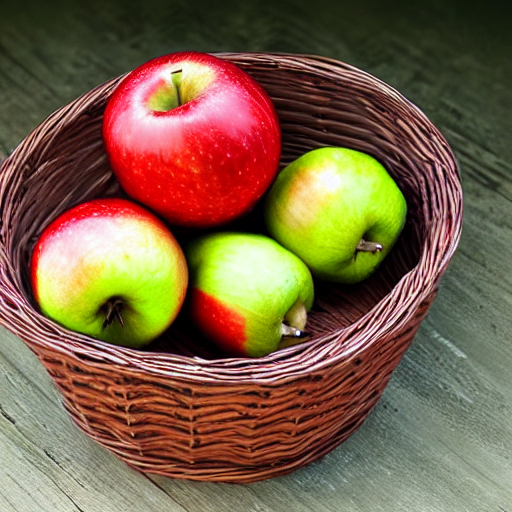

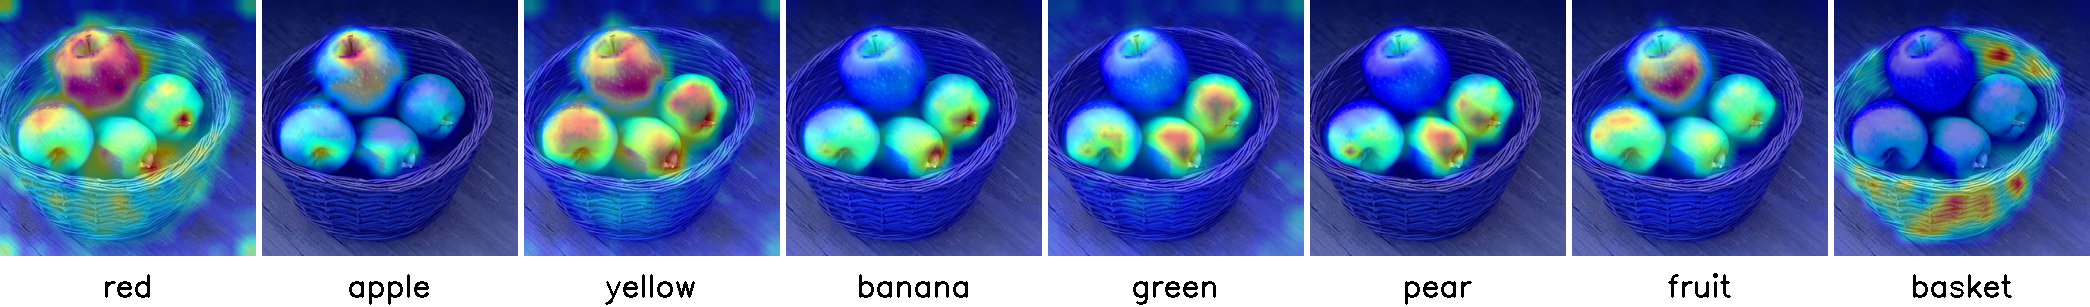

In [52]:
for seed in seeds:
    g = torch.Generator('cuda').manual_seed(seed)
    prompts = [prompt]
    controller = AttentionStore()
    image = run_and_display(prompts=prompts,
                            controller=controller,
                            indices_to_alter=token_indices,
                            groups=None,
                            generator=g,
                            run_standard_sd=True,
                            display_output=True)
    vis_utils.show_cross_attention(attention_store=controller,
                                   prompt=prompt,
                                   tokenizer=tokenizer,
                                   res=16,
                                   from_where=("up", "down", "mid"),
                                   indices_to_alter=token_indices,
                                   orig_image=image)

## Attend-and-Excite

  0%|          | 0/50 [00:00<?, ?it/s]

	 Exceeded max number of iterations (20)! 
	 Finished with loss of: 0.98779296875
Iteration 0 | Loss: 0.9878
Iteration 1 | Loss: 0.9883
Iteration 2 | Loss: 0.9883
Iteration 3 | Loss: 0.9878
Iteration 4 | Loss: 0.9873
Iteration 5 | Loss: 0.9878
Iteration 6 | Loss: 0.9878
Iteration 7 | Loss: 0.9873
Iteration 8 | Loss: 0.9873
Iteration 9 | Loss: 0.9873
	 Exceeded max number of iterations (20)! 
	 Finished with loss of: 0.986328125
Iteration 10 | Loss: 0.9863
Iteration 11 | Loss: 0.9873
Iteration 12 | Loss: 0.9873
Iteration 13 | Loss: 0.9873
Iteration 14 | Loss: 0.9868
Iteration 15 | Loss: 0.9868
Iteration 16 | Loss: 0.9868
Iteration 17 | Loss: 0.9868
Iteration 18 | Loss: 0.9868
Iteration 19 | Loss: 0.9868
	 Exceeded max number of iterations (20)! 
	 Finished with loss of: 0.98681640625
Iteration 20 | Loss: 0.9868
Iteration 21 | Loss: 0.9868
Iteration 22 | Loss: 0.9868
Iteration 23 | Loss: 0.9868
Iteration 24 | Loss: 0.9868


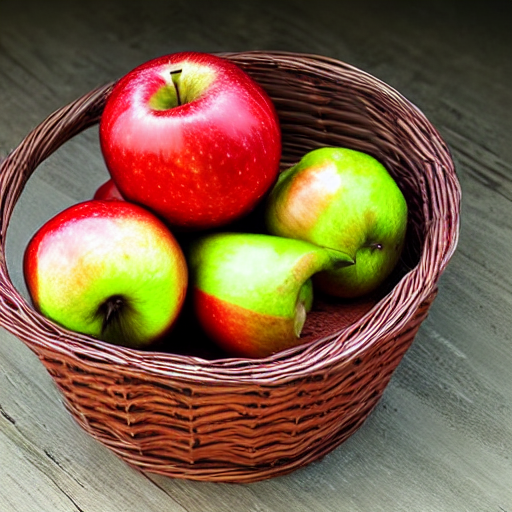

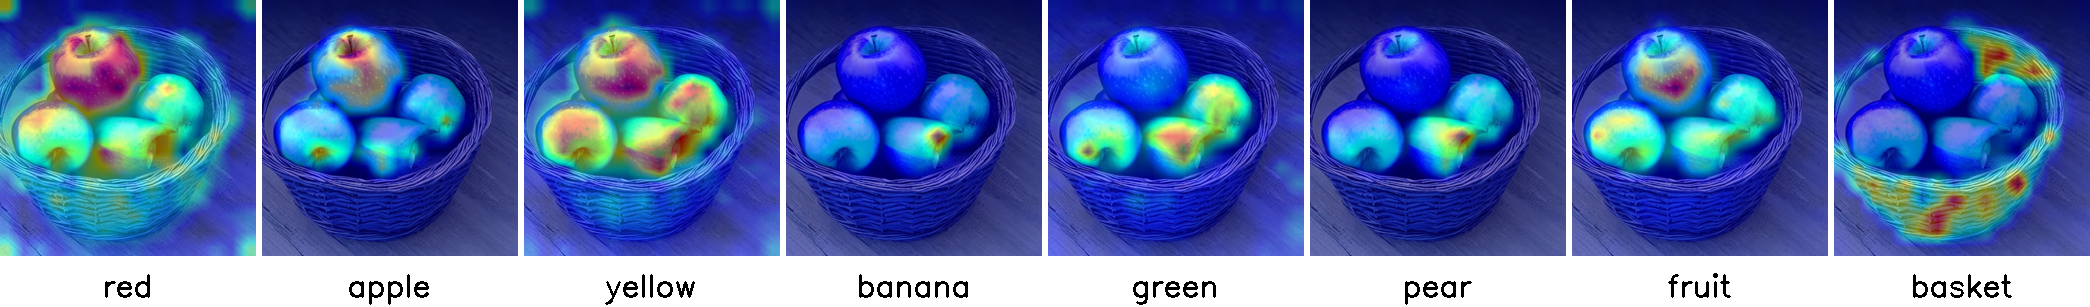

In [53]:
for seed in seeds:
    g = torch.Generator('cuda').manual_seed(seed)
    prompts = [prompt]
    controller = AttentionStore()
    image = run_and_display(prompts=prompts,
                            controller=controller,
                            indices_to_alter=token_indices,
                            groups=None, # regular AE
                            generator=g,
                            run_standard_sd=False,
                            display_output=True)
    vis_utils.show_cross_attention(attention_store=controller,
                                   prompt=prompt,
                                   tokenizer=tokenizer,
                                   res=16,
                                   from_where=("up", "down", "mid"),
                                   indices_to_alter=token_indices,
                                   orig_image=image)

# Our contrastive/adversarial loss

### Cosine loss

Using cos loss with lr 20 


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0 | Loss: 0.4342
Iteration 1 | Loss: 0.4081
Iteration 2 | Loss: 0.4068
Iteration 3 | Loss: 0.3953
Iteration 4 | Loss: 0.3886
Iteration 5 | Loss: 0.3914
Iteration 6 | Loss: 0.3950
Iteration 7 | Loss: 0.3970
Iteration 8 | Loss: 0.4070
Iteration 9 | Loss: 0.4043
Iteration 10 | Loss: 0.4130
Iteration 11 | Loss: 0.4145
Iteration 12 | Loss: 0.4177
Iteration 13 | Loss: 0.4219
Iteration 14 | Loss: 0.4317
Iteration 15 | Loss: 0.4376
Iteration 16 | Loss: 0.4529
Iteration 17 | Loss: 0.4408
Iteration 18 | Loss: 0.4573
Iteration 19 | Loss: 0.4470
	 Exceeded max number of iterations (20)! 
	 Finished with loss of: 0.4159665107727051
Iteration 20 | Loss: 0.4160
Iteration 21 | Loss: 0.4240
Iteration 22 | Loss: 0.4215
Iteration 23 | Loss: 0.4343
Iteration 24 | Loss: 0.4304


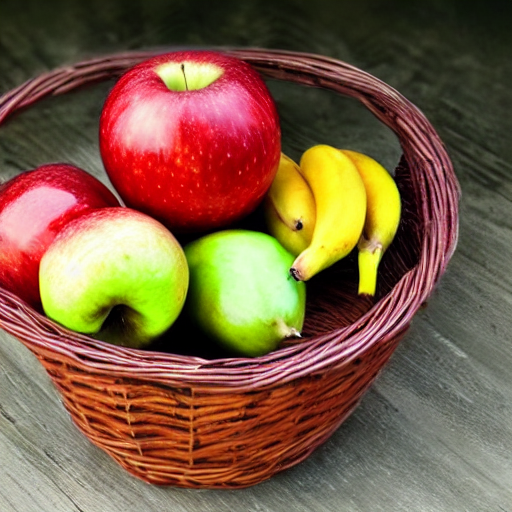

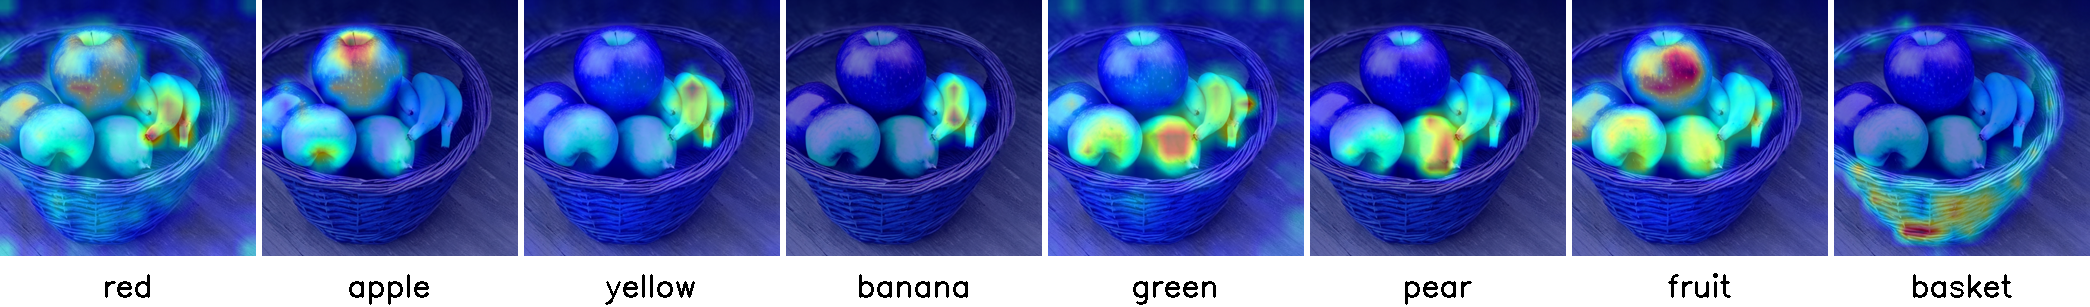

In [55]:
from run import run_on_prompt
loss_type = "cos"

for seed in seeds:
    g = torch.Generator('cuda').manual_seed(seed)
    prompts = [prompt]
    controller = AttentionStore()
    image = run_and_display(prompts=prompts,
                            controller=controller,
                            indices_to_alter=token_indices,
                            groups=token_group, # new losses
                            generator=g,
                            run_standard_sd=False,
                            display_output=True,
                            loss_type=loss_type)
    vis_utils.show_cross_attention(attention_store=controller,
                                   prompt=prompt,
                                   tokenizer=tokenizer,
                                   res=16,
                                   from_where=("up", "down", "mid"),
                                   indices_to_alter=token_indices,
                                   orig_image=image)
torch.cuda.empty_cache()

### Wasserstein loss

In [14]:
from run import run_on_prompt
loss_type = "wasserstein"

for seed in seeds:
    g = torch.Generator('cuda').manual_seed(seed)
    prompts = [prompt]
    controller = AttentionStore()
    image = run_and_display(prompts=prompts,
                            controller=controller,
                            indices_to_alter=token_indices,
                            groups=token_group, # new losses
                            generator=g,
                            run_standard_sd=False,
                            display_output=True,
                            loss_type=loss_type)
    vis_utils.show_cross_attention(attention_store=controller,
                                   prompt=prompt,
                                   tokenizer=tokenizer,
                                   res=16,
                                   from_where=("up", "down", "mid"),
                                   indices_to_alter=token_indices,
                                   orig_image=image)
torch.cuda.empty_cache()

  0%|          | 0/50 [00:00<?, ?it/s]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>                                                                                      │
│                                                                                                  │
│    4 │   g = torch.Generator('cuda').manual_seed(seed)                                           │
│    5 │   prompts = [prompt]                                                                      │
│    6 │   controller = AttentionStore()                                                           │
│ ❱  7 │   image = run_and_display(prompts=prompts,                                                │
│    8 │   │   │   │   │   │   │   controller=controller,                                          │
│    9 │   │   │   │   │   │   │   indices_to_alter=token_indices,                                 │
│   10 │   │   │   │   │   │   │   groups=token_group, # new losses                                │
│                                                                                                  │
│ /nobackup/wenxuan/miniconda3/envs/ldm/lib/python3.8/site-packages/torch/amp/autocast_mode.py:14  │
│ in decorate_autocast                                                                             │
│                                                                                                  │
│    11 │   @functools.wraps(func)                                                                 │
│    12 │   def decorate_autocast(*args, **kwargs):                                                │
│    13 │   │   with autocast_instance:                                                            │
│ ❱  14 │   │   │   return func(*args, **kwargs)                                                   │
│    15 │   decorate_autocast.__script_unsupported = '@autocast() decorator is not supported in    │
│    16 │   return decorate_autocast                                                               │
│    17                                                                                            │
│                                                                                                  │
│ in run_and_display                                                                               │
│                                                                                                  │
│   27 │   │   │   │   │      loss_type=loss_type,                                                 │
│   28 │   │   │   │   │      )                                                                    │
│   29 │                                                                                           │
│ ❱ 30 │   image = run_on_prompt(model=stable,                                                     │
│   31 │   │   │   │   │   │     prompt=prompts,                                                   │
│   32 │   │   │   │   │   │     controller=controller,                                            │
│   33 │   │   │   │   │   │     token_indices=indices_to_alter,                                   │
│                                                                                                  │
│ /data/wenxuan/Stable-Diffusion-Compositions-Analysis/Attend-and-Excite/notebooks/../run.py:99 in │
│ run_on_prompt                                                                                    │
│                                                                                                  │
│    96 │                                                                                          │
│    97 │   if controller is not None:                                                             │
│    98 │   │   ptp_utils.register_attention_control(model, controller)                            │
│ ❱  99 │   outputs = model(prompt=prompt,                                                         │
│   100 │   │   │   │   │   attention_store=controller,      

### Distance correlation

In [27]:
from run import run_on_prompt
loss_type = "dc"

for seed in seeds:
    g = torch.Generator('cuda').manual_seed(seed)
    prompts = [prompt]
    controller = AttentionStore()
    image = run_and_display(prompts=prompts,
                            controller=controller,
                            indices_to_alter=token_indices,
                            groups=token_group, # new losses
                            generator=g,
                            run_standard_sd=False,
                            display_output=True,
                            loss_type=loss_type)
    vis_utils.show_cross_attention(attention_store=controller,
                                   prompt=prompt,
                                   tokenizer=tokenizer,
                                   res=16,
                                   from_where=("up", "down", "mid"),
                                   indices_to_alter=token_indices,
                                   orig_image=image)
torch.cuda.empty_cache()

Using dc loss with lr 20 


  0%|          | 0/50 [00:00<?, ?it/s]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>                                                                                      │
│                                                                                                  │
│    5 │   g = torch.Generator('cuda').manual_seed(seed)                                           │
│    6 │   prompts = [prompt]                                                                      │
│    7 │   controller = AttentionStore()                                                           │
│ ❱  8 │   image = run_and_display(prompts=prompts,                                                │
│    9 │   │   │   │   │   │   │   controller=controller,                                          │
│   10 │   │   │   │   │   │   │   indices_to_alter=token_indices,                                 │
│   11 │   │   │   │   │   │   │   groups=token_group, # new losses                                │
│                                                                                                  │
│ /nobackup/wenxuan/miniconda3/envs/ldm/lib/python3.8/site-packages/torch/amp/autocast_mode.py:14  │
│ in decorate_autocast                                                                             │
│                                                                                                  │
│    11 │   @functools.wraps(func)                                                                 │
│    12 │   def decorate_autocast(*args, **kwargs):                                                │
│    13 │   │   with autocast_instance:                                                            │
│ ❱  14 │   │   │   return func(*args, **kwargs)                                                   │
│    15 │   decorate_autocast.__script_unsupported = '@autocast() decorator is not supported in    │
│    16 │   return decorate_autocast                                                               │
│    17                                                                                            │
│                                                                                                  │
│ in run_and_display                                                                               │
│                                                                                                  │
│   27 │   │   │   │   │      loss_type=loss_type,                                                 │
│   28 │   │   │   │   │      )                                                                    │
│   29 │                                                                                           │
│ ❱ 30 │   image = run_on_prompt(model=stable,                                                     │
│   31 │   │   │   │   │   │     prompt=prompts,                                                   │
│   32 │   │   │   │   │   │     controller=controller,                                            │
│   33 │   │   │   │   │   │     token_indices=indices_to_alter,                                   │
│                                                                                                  │
│ /data/wenxuan/Stable-Diffusion-Compositions-Analysis/Attend-and-Excite/notebooks/../run.py:101   │
│ in run_on_prompt                                                                                 │
│                                                                                                  │
│    98 │                                                                                          │
│    99 │   if controller is not None:                                                             │
│   100 │   │   ptp_utils.register_attention_control(model, controller)                            │
│ ❱ 101 │   outputs = model(prompt=prompt,                                                         │
│   102 │   │   │   │   │   attention_store=controller,      